In [1]:
import sys
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

sys.path.append("./lib")

device = torch.device("cuda")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

### Step 1: Loading the dataset

We prepared our custom Steam dataset with over 80,000 games and corresponding images for each of them. We can read this dataset from the `data` directory using the provided helper functions. In this case, we only load the top N most popular games: as Steam tends to get a lot of asset flips and unfinished games, this should allow us to train our model on images that will actually be useful for classifying real-world images.

In [2]:
import steam.loaders.genre_classification

from pathlib import Path

dataset, metadata = steam.loaders.genre_classification.load(
    steam_games=Path("./data/steam/games.json"),
    top_n_by_popularity=5000,
)

dataset["train"].data.head()

,id,title,image,genres,Action,Adventure,Casual,Early Access,Free to Play,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
41960,1044620,Aokana - Four Rhythms Across the Blue,images/1044620/ss_55fcdb0f1bd4df2cc182f6fcd076...,"[Adventure, Casual]",0,1,1,0,0,0,0,0,0,0,0,0
46708,672630,Academia : School Simulator,images/672630/ss_9d7395e2f0f24b669510d45b49b23...,"[Indie, Simulation, Strategy]",0,0,0,0,0,1,0,0,0,1,0,1
41055,1097130,Circuit Superstars,images/1097130/ss_3a99b9d2b105cb76b014d5d2249d...,"[Action, Casual, Indie, Racing, Simulation, Sp...",1,0,1,0,0,1,0,0,1,1,1,0
21600,1424330,Wobbledogs,images/1424330/ss_b10d95977a5ceb28b639db5eb1cb...,"[Casual, Indie, Simulation]",0,0,1,0,0,1,0,0,0,1,0,0
50520,318850,Saints Row: Gat out of Hell - Devil’s Workshop...,images/318850/ss_48202a1322f1b37199729c0557471...,[Action],1,0,0,0,0,0,0,0,0,0,0,0


Now, we can take a look at the distribution of the different labels. In the case of Steam games, this is going to be heavily unbalanced, which is why we're employing label weights when calculating the BCE loss later. This should allow us to train on the unbalanced dataset while still having a reasonable loss. See [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

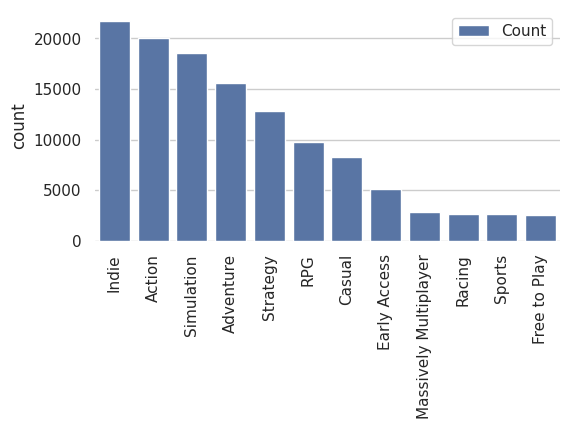

In [3]:
f, ax = plt.subplots(figsize=(6, 3))

sns.barplot(y="count", x="genres", data=metadata.genre_counts, label="Count")
sns.despine(left=True, bottom=True)
ax.set(xlabel="")
ax.tick_params(axis="x", rotation=90)

### Step 2: Creating the model

After some experimentation, I've had varying success with a few different models and I left the best ones in the code, just commented out. All the best models will have a respective model implementation in the `lib/steam/models` folder that supports using weighted labels when computing BCE loss.

In [4]:
import typing
from transformers import AutoImageProcessor, ViTFeatureExtractor
from steam.models import Swinv2ForImbalancedImageClassification

model_id = "microsoft/swinv2-large-patch4-window12to24-192to384-22kto1k-ft"
# model_id = "facebook/dinov2-large"
# model_id = "facebook/convnextv2-large-22k-384"

# This is a pretty ugly hack, but AutoImageProcessor does not have the proper properties (size, image_std, image_mean) and there's no common
# base class that does. So we just use `ViTFeatureExtractor` here to access to properties later without the type checker complaining.
image_processor = typing.cast(ViTFeatureExtractor, AutoImageProcessor.from_pretrained(model_id))
model = typing.cast(Swinv2ForImbalancedImageClassification, Swinv2ForImbalancedImageClassification.from_pretrained(
    model_id,
    problem_type="multi_label_classification",
    num_labels=len(metadata.id2label),
    id2label=metadata.id2label,
    label2id=metadata.label2id,
    label_weights=metadata.label_weights,
    # Some models are pretrained on ImageNet1k and we don't have that many classes
    ignore_mismatched_sizes=True,
))

model.to(device)


ConvNextV2ForImbalancedImageClassification(
  (convnextv2): ConvNextV2Model(
    (embeddings): ConvNextV2Embeddings(
      (patch_embeddings): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextV2LayerNorm()
    )
    (encoder): ConvNextV2Encoder(
      (stages): ModuleList(
        (0): ConvNextV2Stage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextV2Layer(
              (dwconv): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
              (layernorm): ConvNextV2LayerNorm()
              (pwconv1): Linear(in_features=192, out_features=768, bias=True)
              (act): GELUActivation()
              (grn): ConvNextV2GRN()
              (pwconv2): Linear(in_features=768, out_features=192, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextV2Layer(
              (dwconv): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3

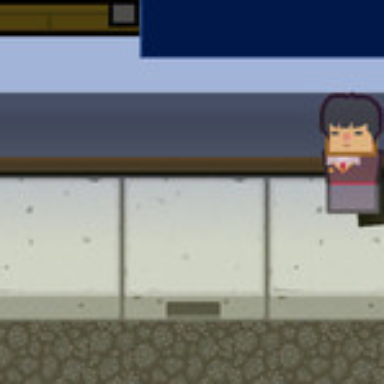

In [5]:
import numpy as np
import PIL.Image

from torchvision.transforms import v2

size = image_processor.size["height"] if "height" in image_processor.size else image_processor.size["shortest_edge"]
mean = typing.cast(list[float], image_processor.image_mean)
std = typing.cast(list[float], image_processor.image_std)

transform = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(size,size), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(p=0.1),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

dataset["train"].set_transform(transform)
dataset["test"].set_transform(transform)

# Denormalize the pixel values to see that the image is also correctly loaded
def inverse_transform(pixel_values: torch.Tensor) -> PIL.Image.Image:
    unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return PIL.Image.fromarray(unnormalized_image)

inverse_transform(dataset["train"][1]["pixel_values"])

In [6]:
from transformers import TrainingArguments, Trainer, EvalPrediction, IntervalStrategy

from steam.metrics.multi_label import create_multi_label_metrics

metrics = create_multi_label_metrics(positive_label_threshold=metadata.positive_label_threshold)

def data_collator(batch: list[dict[str, torch.Tensor]]):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    return { "pixel_values": pixel_values, "labels": labels }

def compute_metrics(p: EvalPrediction):
    predictions = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    labels = p.label_ids[0] if isinstance(p.label_ids, tuple) else p.label_ids
    result = metrics(predictions=predictions, labels=labels)
    return result

training_args = TrainingArguments(
    output_dir="./data/steam_genre_classifier",
    remove_unused_columns=False,
    evaluation_strategy=IntervalStrategy.STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_total_limit=10,
    eval_steps=250,
    save_steps=250,
    learning_rate=5e-5,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    label_names=["labels"],
    tf32=True,
    bf16=True,
    optim="adamw_bnb_8bit",
    # Comment these out when testing new models to check for CUDA OOM errors quicker, but for debugging, it just makes things more difficult
    # torch_compile=True,
    # torch_compile_backend="inductor",
    # torch_compile_mode="reduce-overhead"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()